In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pymc as pm
from sklearn.metrics import mean_squared_error, r2_score
import arviz as az
import pytensor.tensor as pt
from scipy.stats import truncnorm

In [10]:
layoffs_df = pd.read_csv("cleaned_layoffs.csv")
X = layoffs_df.drop(columns=['percentage_laid_off'], axis=1)
y = layoffs_df['percentage_laid_off']

X_scaled = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)

In [4]:
n_hidden = 16

with pm.Model() as bnn_model:
    alpha0 = 2.0
    beta0 = 1.0
    sigma2_y = pm.InverseGamma("sigma2_y", alpha=alpha0, beta=beta0)
    sigma_y = pm.Deterministic("sigma_y", pt.sqrt(sigma2_y))

    mu0_1, sigma0_1 = 0.0, 1.0
    w1 = pm.Normal("w1", mu=mu0_1, sigma=sigma0_1, shape=(X_train.shape[1], n_hidden))

    mu0_2, sigma0_2 = 0.0, 1.0
    w2 = pm.Normal("w2", mu=mu0_2, sigma=sigma0_2, shape=(n_hidden))

    layer_1 = pt.dot(X_train, w1)
    layer_1_sigmoid = pt.sigmoid(layer_1)


    layer_2 = pt.dot(layer_1_sigmoid, w2)
    layer_2_sigmoid = pt.sigmoid(layer_2)  
    
    y_obs_train = pm.TruncatedNormal("y_obs_train", mu=layer_2_sigmoid, sigma=sigma_y, observed=y_train, lower=0, upper=1)

    trace_train = pm.sample(1000, tune=180, target_accept=0.95, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma2_y, w1, w2]


Output()

Sampling 4 chains for 180 tune and 1_000 draw iterations (720 + 4_000 draws total) took 52 seconds.


          mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sigma2_y  0.07  0.00    0.06     0.08       0.00     0.00   5624.75   3507.81   
sigma_y   0.26  0.01    0.24     0.27       0.00     0.00   5624.75   3507.81   
w1[0, 0]  0.01  1.00   -1.78     1.92       0.01     0.02  10281.55   2857.06   
w1[0, 1] -0.01  0.96   -1.70     1.87       0.01     0.02   8594.65   2917.29   
w1[0, 2] -0.00  1.00   -1.90     1.81       0.01     0.02   8349.46   2488.28   
...        ...   ...     ...      ...        ...      ...       ...       ...   
w2[11]   -0.19  1.34   -2.66     2.31       0.03     0.02   1574.80   2532.55   
w2[12]   -0.22  1.33   -2.70     2.30       0.03     0.02   1596.22   2404.83   
w2[13]   -0.16  1.34   -2.58     2.37       0.03     0.02   1674.33   2969.71   
w2[14]   -0.22  1.33   -2.90     2.12       0.03     0.02   1708.04   2683.96   
w2[15]   -0.22  1.33   -2.73     2.20       0.03     0.02   1481.93   2688.24   

          r_hat  
sigma2_y 

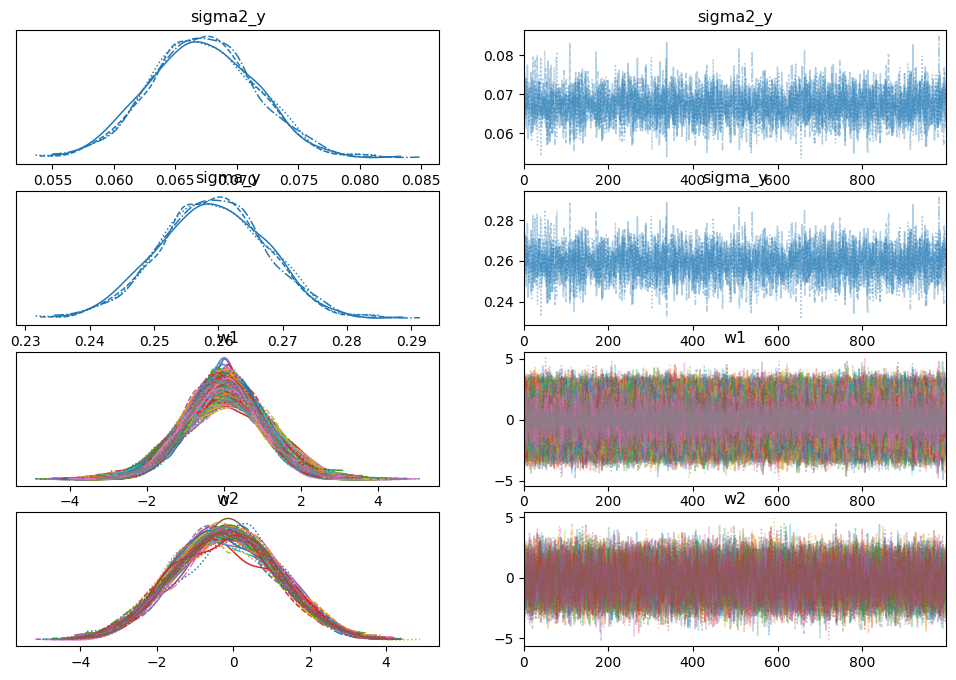

In [5]:
print(az.summary(trace_train, round_to=2))
az.plot_trace(trace_train,  var_names=["sigma2_y", "sigma_y", "w1", "w2"])
plt.show()

In [6]:
with bnn_model:
    post_preds_mix = pm.sample_posterior_predictive(trace_train, var_names=["sigma2_y", "sigma_y", "w1", "w2"])

Sampling: [sigma2_y, w1, w2]


Output()

In [7]:
posterior_w1_mean = np.mean(np.mean(post_preds_mix.posterior_predictive["w1"].values, axis=0), axis=0)
posterior_w2_mean = np.mean(np.mean(post_preds_mix.posterior_predictive["w2"].values, axis=0), axis=0)
posterior_sigma_y_mean = np.mean(np.mean(post_preds_mix.posterior_predictive["sigma_y"].values, axis=0), axis=0)

y_hat = []

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

for i in range(X_test.shape[0]):
    obs = X_test[i]

    layer_1 = np.dot(obs, posterior_w1_mean)
    post_1 = sigmoid(layer_1)
    
    layer_2 = np.dot(post_1, posterior_w2_mean)  
    post_2 = sigmoid(layer_2)
    
    a, b = (0 - post_2) / posterior_sigma_y_mean, (1 - post_2) / posterior_sigma_y_mean
    output = truncnorm.rvs(a, b, loc=layer_2, scale=posterior_sigma_y_mean)
    y_hat.append(np.round(output, 2))

In [8]:
# Model works very poorly
print(r2_score(y_test.values, y_hat))

-2.7511808524819785
